# *Importing Necessary Libraries*

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# **Loading & Pre-Processing Training, Testing and Validation Images**

In [ ]:
path_for_training = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Training Data'
path_for_validation = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Validation Data'
path_for_testing = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Testing Data'

def loading_images_and_categories(directory):
    images, labels = [], []
    total_count = 0

    for category in os.listdir(directory):
        current_path = os.path.join(directory, category)
        for img in os.listdir(current_path):
            img_path = os.path.join(current_path, img)
            images.append(np.array(Image.open(img_path).convert('L')))
            labels.append(category)
            total_count += 1

    return total_count, images, labels

train_count, X_train, y_train = loading_images_and_categories(path_for_training)
val_count, X_val, y_val = loading_images_and_categories(path_for_validation)
test_count, X_test, y_test = loading_images_and_categories(path_for_testing)

categories = os.listdir(path_for_training)
print("Unique Categories are", categories)
print("Number of Training images:", train_count)
print("Number of Validation images:", val_count)
print("Number of Testing images:", test_count)

Unique Categories are ['Mountain', 'Coast', 'Desert', 'Forest', 'Glacier']
Number of Training images: 10000
Number of Validation images: 1500
Number of Testing images: 500


# **Converting to Gray Scale and Displaying some sample images**

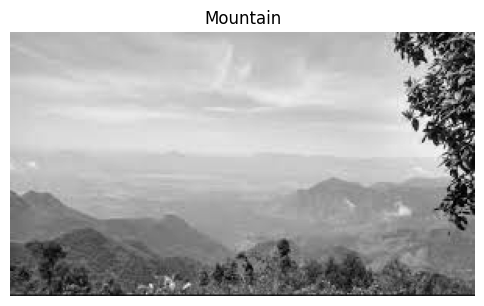

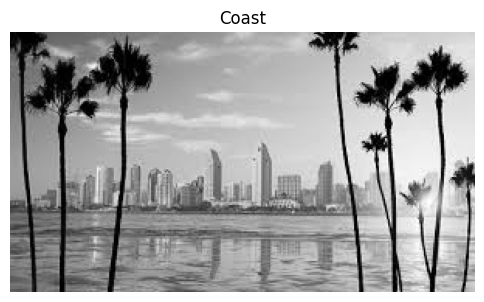

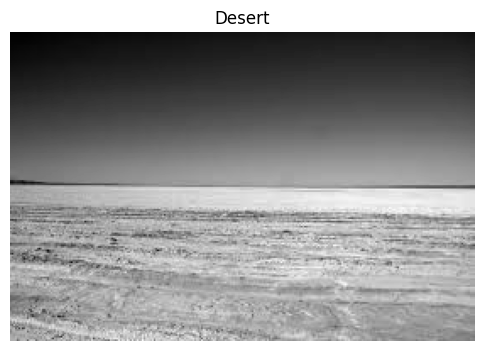

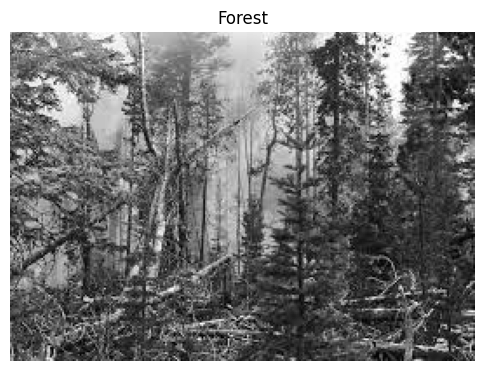

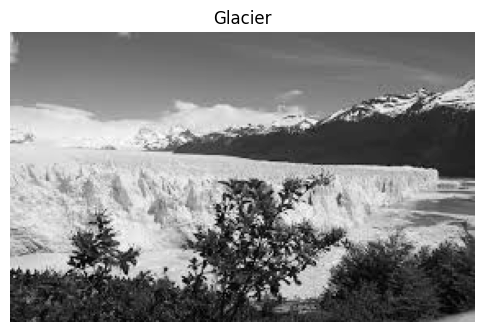

In [ ]:
for category in categories:
    category_indices = [idx for idx, label in enumerate(y_train) if label == category]
    if category_indices:
        image = X_train[category_indices[0]]
        plt.figure(figsize=(6, 6))
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title(category)
        plt.show()
    print()

# *Encoding the Image Labels*

In [ ]:
def label_encoding(y):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(y)
    return encoded_labels, label_encoder.classes_

# Encoding the Training Dataset
encoded_y_train, label_classes = label_encoding(y_train)

print("Label Classes: ", label_classes)
print("Encoded Labels: ", encoded_y_train)

Label Classes:  ['Coast' 'Desert' 'Forest' 'Glacier' 'Mountain']
Encoded Labels:  [4 4 4 ... 3 3 3]


In [ ]:
# Encoding the Testing Dataset
encoded_y_test, label_classes_test = label_encoding(y_test)

print("Encoded Labels: ", encoded_y_test)
print("Label Classes: ", label_classes_test)

Encoded Labels:  [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3

# **GIST Feature Extraction**

In [ ]:
class GaborFeatureExtractor:
    def __init__(self, resize_dim=(128, 128), grid_size=(4, 4)):
        self.resize_dim = resize_dim
        self.grid_size = grid_size
        self.filters = self._create_gabor_filters()

    # Resizing an image to the specified dimensions
    def resize_image(self, image):
        return cv2.resize(image, self.resize_dim)

    # Generating a set of Gabor filters with specified scales and orientations
    def _create_gabor_filters(self):
        filters = []
        scale_orientation_map = {4: 8, 8: 8}

        for scale, orientation_count in scale_orientation_map.items():
            theta_values = np.linspace(0, np.pi, orientation_count, endpoint=False)
            for theta in theta_values:
                ksize = (31, 31)
                sigma = 4
                lambd = scale
                gamma = 0.5
                psi = 0

                gabor_kernel = cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
                filters.append(gabor_kernel)
        return filters

    # Calculating GIST features for an image using a grid-based approach
    def get_gist_features(self, image):
        image_height, image_width = image.shape
        cell_height, cell_width = image_height // self.grid_size[0], image_width // self.grid_size[1]
        gist_features = []

        for filter in self.filters:
            filtered_img = cv2.filter2D(image, cv2.CV_32F, filter)
            for i in range(self.grid_size[0]):
                for j in range(self.grid_size[1]):
                    cell = filtered_img[i * cell_height:(i + 1) * cell_height, j * cell_width:(j + 1) * cell_width]
                    gist_features.append(cell.mean())

        return np.array(gist_features), filtered_img

    # Extracting GIST features for a dataset of images
    def extract_features_from_dataset(self, dataset):
        feature_set = []

        for img in dataset:
            resized_img = self.resize_image(img)
            gist_features, _ = self.get_gist_features(resized_img)
            feature_set.append(gist_features)

        return np.array(feature_set), self.filters

    # Plotting the Gabor filters
    def plot_gabor_filters(self):
        # Create a figure with 2 rows and 8 columns
        fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 4))
        axes = axes.ravel()  # Flatten the axes array for easy indexing

        # Plotting each Gabor filter
        for i, gabor_filter in enumerate(self.filters):
            axes[i].imshow(gabor_filter, cmap='gray')
            axes[i].axis('off')

        # Turning off any unused subplots
        for j in range(len(self.filters), len(axes)):
            axes[j].axis('off')

        plt.suptitle('Gabor Filter Bank', fontsize=16)
        plt.tight_layout()
        plt.show()


    # Displaying an image with a grid overlay
    def show_image_with_grid(self, image):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(image, cmap='gray')

        height, width = image.shape
        cell_height, cell_width = height // self.grid_size[0], width // self.grid_size[1]

        for i in range(1, self.grid_size[0]):
            ax.axhline(i * cell_height, color='red')
        for j in range(1, self.grid_size[1]):
            ax.axvline(j * cell_width, color='red')

        ax.set_title("Image with 4x4 Grid Overlay")
        plt.show()

    # Displaying a single filtered image
    def display_filtered_image(self, filtered_image):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(filtered_image, cmap='gray')
        ax.set_title("Filtered Image (First Gabor Filter)")
        plt.show()

### ***Extracting GIST Feature on Training dataset***

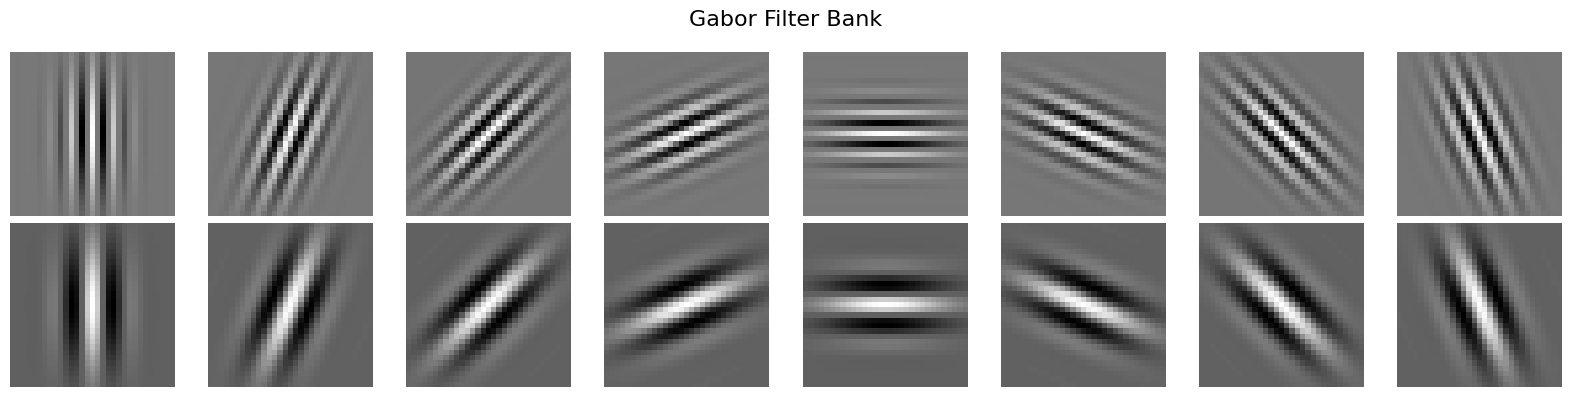

In [ ]:
extractor = GaborFeatureExtractor()
gist_features_X_train, gabor_filters = extractor.extract_features_from_dataset(X_train)

# Plotting Gabor Filters
extractor.plot_gabor_filters()

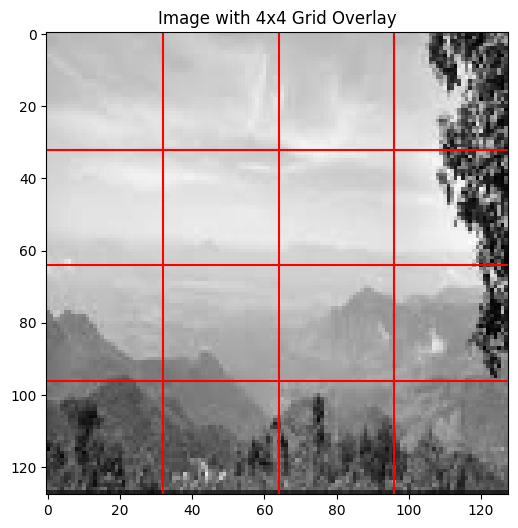

In [ ]:
# Dividing Images into Grid
grid_image = extractor.resize_image(X_train[0])
extractor.show_image_with_grid(grid_image)

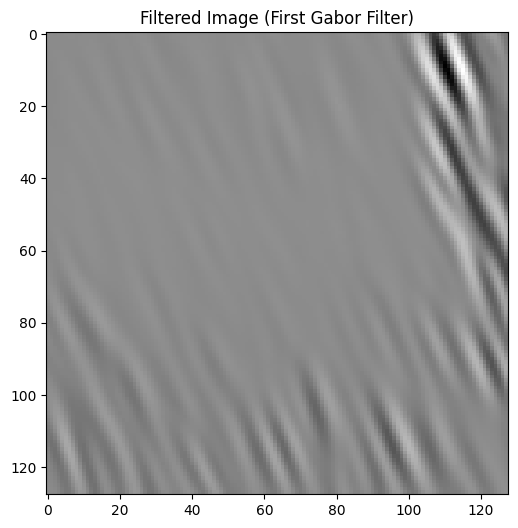

In [ ]:
# Applying Filter on the Grid Image
_, filtered_grid_image = extractor.get_gist_features(grid_image)
extractor.display_filtered_image(filtered_grid_image)

### ***Extracting GIST Feature on Testing dataset***

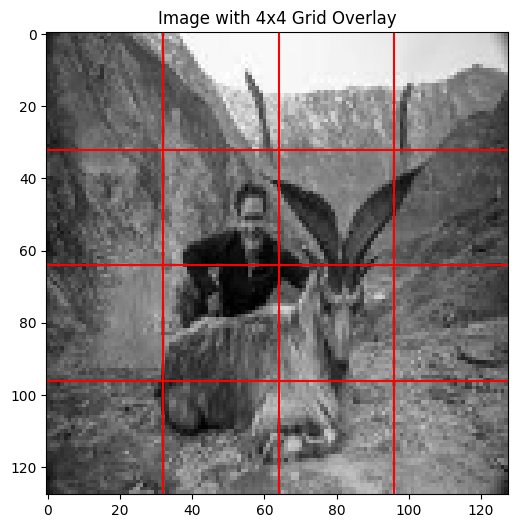

In [ ]:
gist_features_X_test, gabor_filters = extractor.extract_features_from_dataset(X_test)
test_grid_image = extractor.resize_image(X_test[0])
extractor.show_image_with_grid(test_grid_image)

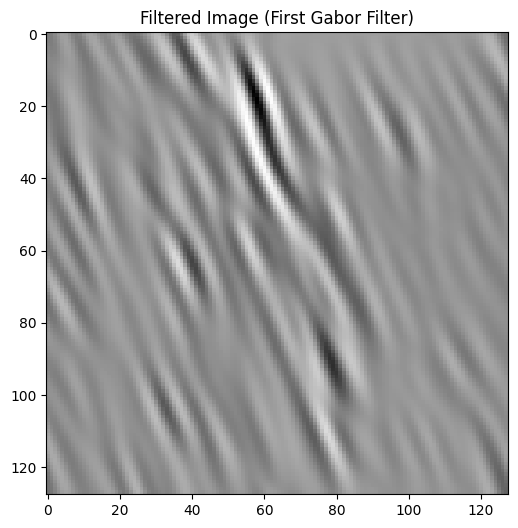

In [ ]:
_, test_filtered_image = extractor.get_gist_features(test_grid_image)
extractor.display_filtered_image(test_filtered_image)

# **Quantising GIST Features using K-Means**

In [ ]:
def quantise_gist_features(gist_features_dataset, num_clusters):
    n_samples, n_features = gist_features_dataset.shape

    quantised_features = np.zeros_like(gist_features_dataset, dtype=int)
    cluster_centres_list = []

    for feature_index in range(n_features):
        feature_output = gist_features_dataset[:, feature_index].reshape(-1, 1)

        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
        kmeans.fit(feature_output)

        quantised_features[:, feature_index] = kmeans.labels_

        cluster_centres_list.append(kmeans.cluster_centers_)

    print("Quantisation completed!")
    print(f"Original feature range: [{gist_features_dataset.min():.3f}, {gist_features_dataset.max():.3f}]")
    print(f"Quantised feature range: [{quantised_features.min()}, {quantised_features.max()}]")
    print(f"Number of quantisation levels per feature is {num_clusters}")

    return quantised_features, cluster_centres_list

num_clusters = 10
quantised_gist_features_train, cluster_centres = quantise_gist_features(gist_features_X_train, num_clusters)

Quantisation completed!
Original feature range: [-242.331, 610.138]
Quantised feature range: [0, 9]
Number of quantisation levels per feature is 10


In [ ]:
n_samples, n_features = gist_features_X_test.shape
quantised_gist_features_test = np.zeros_like(gist_features_X_test, dtype=int)

for feature_index in range(n_features):
    feature_output = gist_features_X_test[:, feature_index].reshape(-1, 1)
    centres = cluster_centres[feature_index]

    # Computing distances to cluster centres
    distances = cdist(feature_output, centres)

    # Assigning to the nearest cluster
    quantised_gist_features_test[:, feature_index] = np.argmin(distances, axis=1)

print(f"Training features shape: {quantised_gist_features_train.shape}")
print(f"Test features shape: {quantised_gist_features_test.shape}")

Training features shape: (10000, 256)
Test features shape: (500, 256)


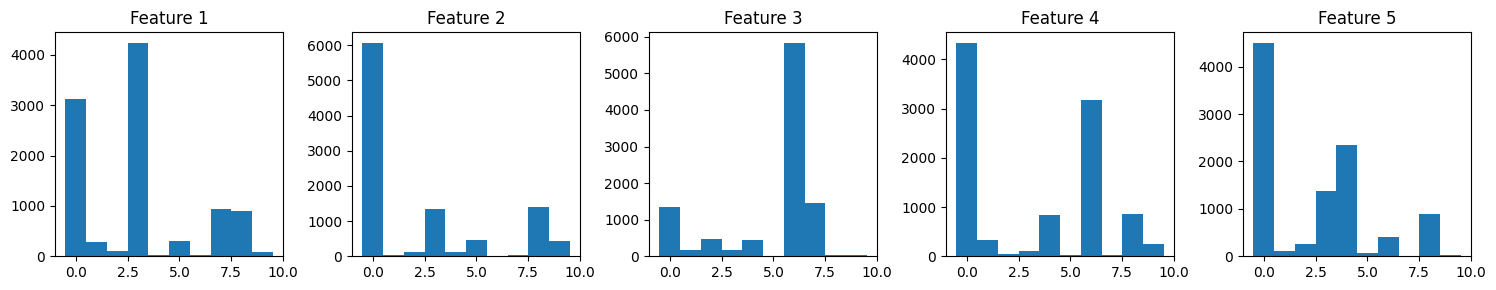

In [ ]:
def display_quantisation_distribution(quantised_features, num_features=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_features):
        plt.subplot(1, num_features, i+1)
        plt.hist(quantised_features[:, i], bins=range(num_clusters + 1), align='left')
        plt.title(f'Feature {i+1}')
    plt.tight_layout()
    plt.show()

display_quantisation_distribution(quantised_gist_features_train)

# **BAYESIAN NETWORK**

In [ ]:
class BayesianNetworkClassifier:
    def __init__(self, smoothing=1e-5):
        # Laplace smoothing parameter
        self.smoothing = smoothing
        # Class prior probabilities
        self.priors = {}
        # Likelihoods P(X|C)
        self.likelihoods = {}
        # Number of features
        self.num_features = None
        # List of class labels
        self.classes = None

    def fit(self, X_train, y_train):
        self.num_samples, self.num_features = X_train.shape
        self.classes = np.unique(y_train)
        self.num_classes = len(self.classes)

        for cls in self.classes:
            idx = np.where(y_train == cls)[0]
            X_train_cls = X_train[idx]
            self.priors[cls] = self._calculate_prior(y_train, cls)
            self.likelihoods[cls] = self._calculate_likelihoods(X_train_cls)

    def _calculate_prior(self, y_train, cls):
        total_count = len(y_train)
        class_count = np.sum(y_train == cls)
        prior = class_count / total_count
        return prior

    def _calculate_likelihoods(self, X_train_cls):
        feature_likelihoods = [{} for _ in range(self.num_features)]

        for idx in range(self.num_features):
            feature_data = X_train_cls[:, idx]

            unique_values, value_counts = np.unique(feature_data, return_counts=True)
            total_count = value_counts.sum()
            probability_map = {}

            for value, count in zip(unique_values, value_counts):
                probability_map[value] = (count + self.smoothing) / (total_count + self.smoothing * len(unique_values))

            feature_likelihoods[idx] = probability_map

        return feature_likelihoods


    def predict(self, X_test):
        num_samples = X_test.shape[0]
        predicted_labels = np.zeros(num_samples, dtype=int)

        for sample_idx in range(num_samples):
            test_sample = X_test[sample_idx]
            class_log_posteriors = {}

            for class_label in self.classes:
                class_prior = self.priors[class_label]
                feature_likelihoods = self.likelihoods[class_label]

                total_log_posterior = np.log(class_prior + self.smoothing)

                for feat_idx in range(self.num_features):
                    sample_feature_val = test_sample[feat_idx]
                    feature_probs = feature_likelihoods[feat_idx]

                    likelihood = feature_probs.get(sample_feature_val, self.smoothing)
                    total_log_posterior += np.log(likelihood)

                class_log_posteriors[class_label] = total_log_posterior

            predicted_labels[sample_idx] = max(class_log_posteriors, key=class_log_posteriors.get)

        return predicted_labels


    def evaluate(self, X_test, y_test, class_names=None):
        predictions = self.predict(X_test)
        acc = accuracy_score(y_test, predictions)
        print(f"Accuracy: {acc * 100:.2f}%")
        if class_names:
            print(classification_report(y_test, predictions, target_names=class_names))
        else:
            print(classification_report(y_test, predictions))

        cm = confusion_matrix(y_test, predictions)
        self.plot_confusion_matrix(cm, classes=class_names if class_names else self.classes, title="Confusion Matrix")

    def plot_confusion_matrix(self, cm, classes,
                              normalize=False,
                              title='Confusion Matrix',
                              cmap=plt.cm.Blues):
        plt.figure(figsize=(6, 6))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()

        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment='center',
                     color='white' if cm[i, j] > thresh else 'black')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

## *Applying Bayesian Network*

Evaluating on Training set...
Accuracy: 40.84%
              precision    recall  f1-score   support

       Coast       0.37      0.24      0.29      2000
      Desert       0.51      0.18      0.27      2000
      Forest       0.47      0.70      0.56      2000
     Glacier       0.36      0.53      0.43      2000
    Mountain       0.37      0.39      0.38      2000

    accuracy                           0.41     10000
   macro avg       0.42      0.41      0.39     10000
weighted avg       0.42      0.41      0.39     10000



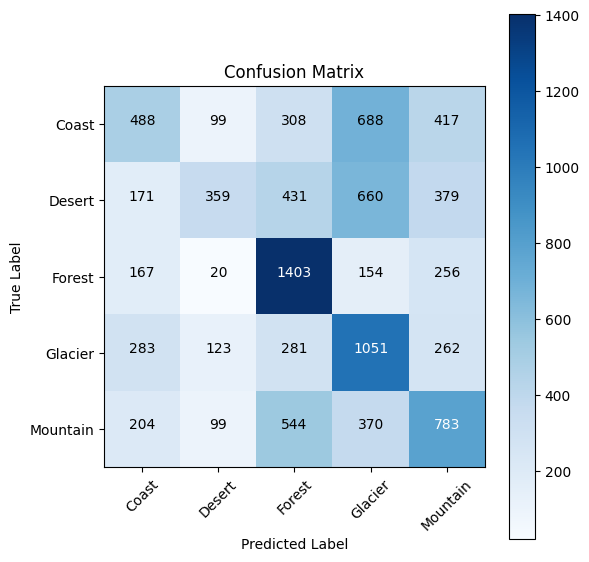

In [ ]:
classifier = BayesianNetworkClassifier(smoothing=1e-5)

classifier.fit(quantised_gist_features_train, encoded_y_train)

class_names = ['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']

print("Evaluating on Training set...")
classifier.evaluate(quantised_gist_features_train, encoded_y_train, class_names=class_names)

Evaluating on Testing set...
Accuracy: 41.00%
              precision    recall  f1-score   support

       Coast       0.29      0.19      0.23       100
      Desert       0.48      0.20      0.28       100
      Forest       0.62      0.71      0.66       100
     Glacier       0.32      0.59      0.41       100
    Mountain       0.40      0.36      0.38       100

    accuracy                           0.41       500
   macro avg       0.42      0.41      0.39       500
weighted avg       0.42      0.41      0.39       500



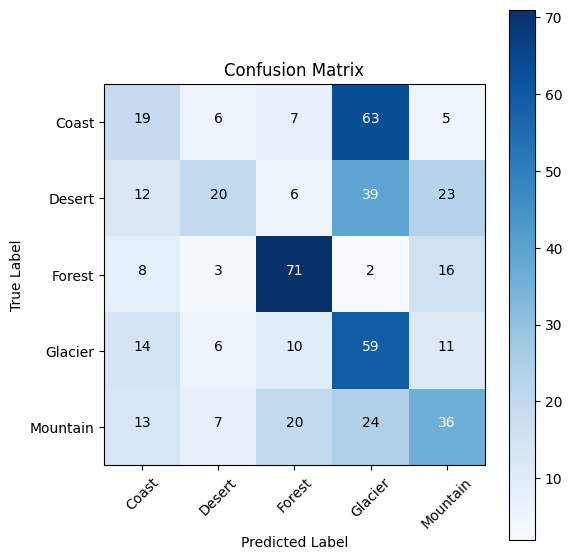

In [ ]:
print("Evaluating on Testing set...")
classifier.evaluate(quantised_gist_features_test, encoded_y_test, class_names=class_names)

### *Increasing to 100 clusters...*

In [ ]:
num_clusters = 100
quantised_gist_features_train, cluster_centres = quantise_gist_features(gist_features_X_train, num_clusters)

Quantisation completed!
Original feature range: [-242.331, 610.138]
Quantised feature range: [0, 99]
Number of quantisation levels per feature is 100


In [ ]:
n_samples, n_features = gist_features_X_test.shape
quantised_gist_features_test = np.zeros_like(gist_features_X_test, dtype=int)

for feature_index in range(n_features):
    feature_output = gist_features_X_test[:, feature_index].reshape(-1, 1)
    centres = cluster_centres[feature_index]

    # Computing distances to cluster centres
    distances = cdist(feature_output, centres)

    # Assigning to the nearest cluster
    quantised_gist_features_test[:, feature_index] = np.argmin(distances, axis=1)

print(f"Training features shape: {quantised_gist_features_train.shape}")
print(f"Test features shape: {quantised_gist_features_test.shape}")

Training features shape: (10000, 256)
Test features shape: (500, 256)


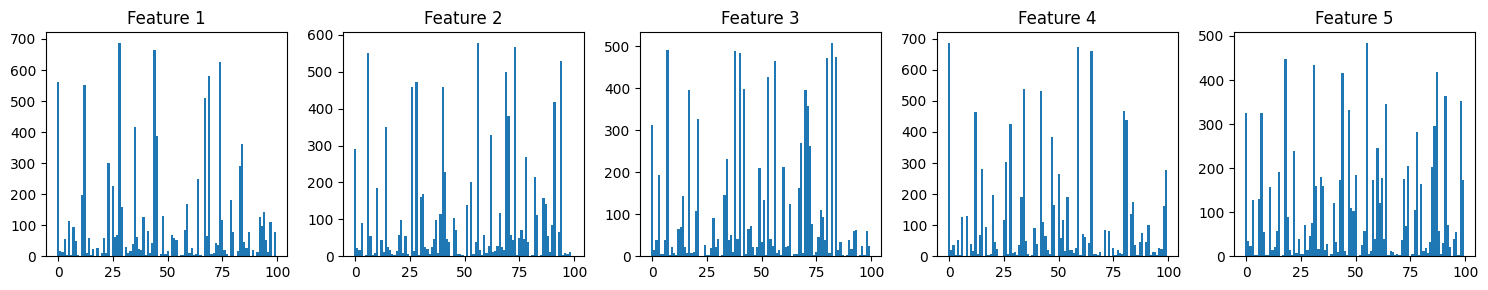

In [ ]:
display_quantisation_distribution(quantised_gist_features_train)

Evaluating on Training set...
Accuracy: 57.97%
              precision    recall  f1-score   support

       Coast       0.70      0.54      0.61      2000
      Desert       0.82      0.42      0.55      2000
      Forest       0.52      0.75      0.61      2000
     Glacier       0.53      0.68      0.59      2000
    Mountain       0.52      0.52      0.52      2000

    accuracy                           0.58     10000
   macro avg       0.62      0.58      0.58     10000
weighted avg       0.62      0.58      0.58     10000



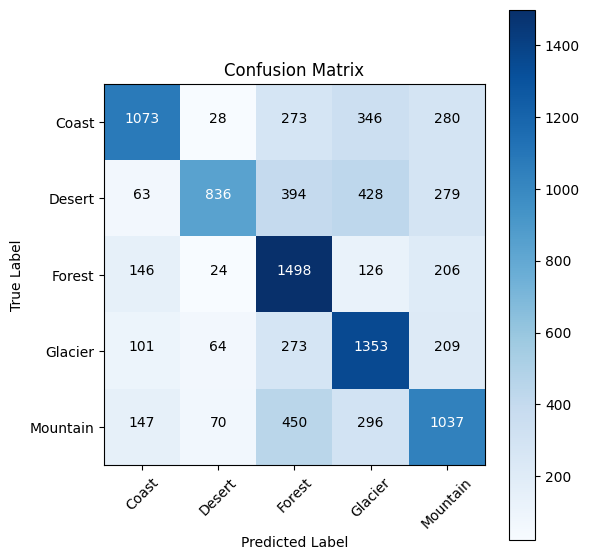

In [ ]:
classifier = BayesianNetworkClassifier(smoothing=1e-5)

classifier.fit(quantised_gist_features_train, encoded_y_train)

print("Evaluating on Training set...")
classifier.evaluate(quantised_gist_features_train, encoded_y_train, class_names=class_names)

Evaluating on Testing set...
Accuracy: 46.20%
              precision    recall  f1-score   support

       Coast       0.39      0.34      0.36       100
      Desert       0.61      0.27      0.38       100
      Forest       0.65      0.75      0.70       100
     Glacier       0.34      0.57      0.42       100
    Mountain       0.45      0.38      0.41       100

    accuracy                           0.46       500
   macro avg       0.49      0.46      0.45       500
weighted avg       0.49      0.46      0.45       500



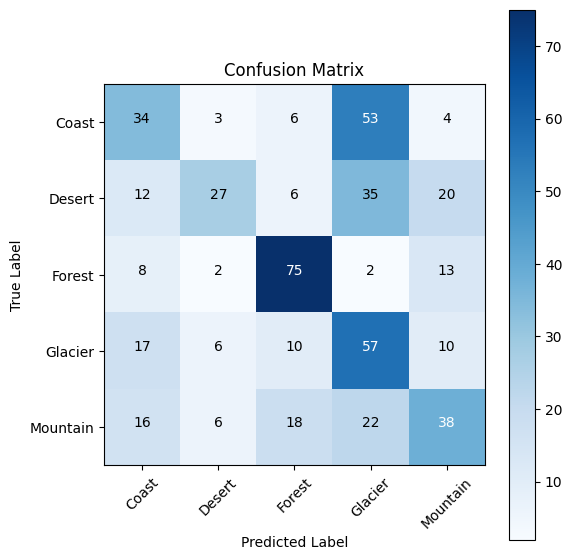

In [ ]:
print("Evaluating on Testing set...")
classifier.evaluate(quantised_gist_features_test, encoded_y_test, class_names=class_names)